In [6]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/wsl/lib'

In [7]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation, ObservationLong
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import SourceDetectionResult, PyBDSFSourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from karabo.simulation.visibility import Visibility
# Render plots inline
%matplotlib inline

In [8]:
def create_random_sources(num_sources, ranges):
    """
    Create a random set of sources.

    :param num_sources: number of sources to create
    :param ranges: list of ranges for each parameter. 
    
    Description of ranges:

    - [0] right ascension (deg)-
    - [1] declination (deg)
    - [2] stokes I Flux (Jy)
    - [3] stokes Q Flux (Jy): defaults to 0
    - [4] stokes U Flux (Jy): defaults to 0
    - [5] stokes V Flux (Jy): defaults to 0
    - [6] reference_frequency (Hz): defaults to 0
    - [7] spectral index (N/A): defaults to 0
    - [8] rotation measure (rad / m^2): defaults to 0
    - [9] major axis FWHM (arcsec): defaults to 0
    - [10] minor axis FWHM (arcsec): defaults to 0
    - [11] position angle (deg): defaults to 0
    - [12] source id (object): defaults to None
    """

    sources = np.column_stack(
        (
            np.random.uniform(min_val, max_val, num_sources)
            for min_val, max_val in ranges
        )
    )

    return sources


/tmp/ipykernel_5161/1059202742.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sources = np.column_stack(


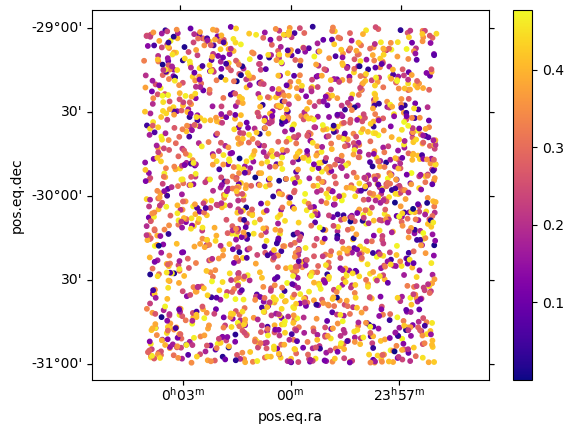

In [9]:
sky = SkyModel()
sky_data = create_random_sources(2028, [[-1, 1], [-29, -31], [1, 3], [0, 2], [0, 2], [0, 2], [100.0e6, 100.0e6], [-0.7, -0.7], [0.0, 0.0], [0, 600], [50, 50], [45, 45]])
sky.add_point_sources(sky_data)
sky.explore_sky([0, -30], s=10)

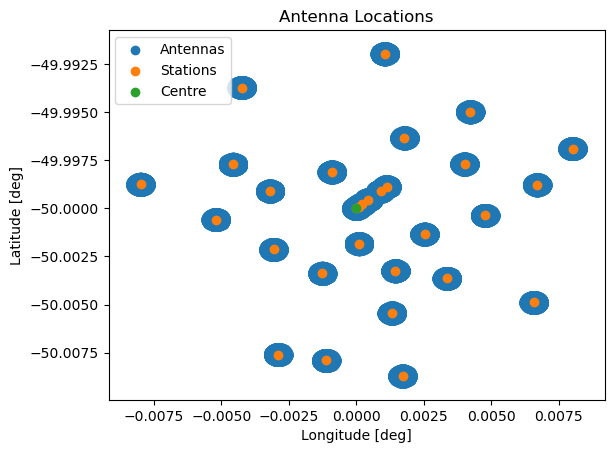

In [10]:
telescope = Telescope.get_OSKAR_Example_Telescope()
telescope.plot_telescope()

In [11]:
def observation_length_integration_time_to_time_steps(observation_length, integration_time):
    return int(observation_length.total_seconds() / integration_time.total_seconds())
    
TOTAL_OBSERVATION_LENGTH = timedelta(hours=100)
DAILY_OBSERVATION_LENGTH = timedelta(hours=4)
INTEGRATION_TIME = timedelta(seconds=10)

observation_settings = ObservationLong(
    # length=4 hours
    start_frequency_hz=100e6,
    phase_centre_ra_deg=0,
    phase_centre_dec_deg=-30,
    number_of_channels=2,
    number_of_time_steps=observation_length_integration_time_to_time_steps(DAILY_OBSERVATION_LENGTH, INTEGRATION_TIME),
    number_of_days=2,#int(TOTAL_OBSERVATION_LENGTH / DAILY_OBSERVATION_LENGTH),
    length=DAILY_OBSERVATION_LENGTH,
)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e5, vis_path='./data/visibilities.ms')
visibilities = interferometer_sim.run_simulation(telescope, sky, observation_settings)

use_gpu is None, using is_cuda_available() to set use_gpu to True
Observing Day: 0 the 2023-02-01 14:10:41.519960
./data/visibilities.ms/beam_vis_0.vis
Observing Day: 1 the 2023-02-01 14:10:41.519960
./data/visibilities.ms/beam_vis_1.vis


In [12]:
combined_vis_filepath = os.path.join("data", "combined_vis.ms")

In [14]:
Visibility.combine_vis(2, visibilities, combined_vis_filepath)
visibilties = Visibility(combined_vis_filepath)

### Combining the visibilities for  ['./data/visibilities.ms/beam_vis_0.vis', './data/visibilities.ms/beam_vis_1.vis']
### Writing combined visibilities in  data/combined_vis.ms


RuntimeError: Input data dimension mismatch.

In [37]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

In [38]:
imager_askap = Imager(
    visibilties,
    imaging_npixel = imaging_npixel,
    imaging_cellsize = imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title='Dirty image')

NameError: name 'visibilties' is not defined